# Encode Analysis

## Imports

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import time

matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)

### Data Download

In [2]:
workingDirectory = '/home/jtao/analysis/encode_analysis/'
os.chdir(workingDirectory)

In [ ]:
%%bash
# data downloaded from:
# https://www.encodeproject.org/search/?type=Experiment&biosample_term_name=K562&assay_title=ChIP-seq&target.investigated_as=transcription+factor&files.file_type=bed+narrowPeak&limit=all&replication_type=isogenic&assembly=GRCh38
# K562 cells
# Encode 2 and 3
# hg38
# target of assay: transcription factor
# bed narrowPeak
# isogenic replicates
# files .txt downloaed from encodeproject.org interface
xargs -n 1 curl -O -L < files.txt

In [81]:
! mkdir ./download
!mv ./*gz ./download/

In [3]:
metadata_frame = pd.read_csv('./metadata.tsv', sep='\t')

In [4]:
targets = sorted(set(metadata_frame['Experiment target'].values))

untagged_targets = [x for x in targets if not 'GFP' in x]

In [5]:
# get rows specifying:
# optimal idr threshold peaks
# untagged protein targets
# aligned to hg38
# K562 cell line
# no audit issues
filtered_metadata_frame = metadata_frame[(metadata_frame['Output type'] == 'optimal idr thresholded peaks') &
                                         (metadata_frame['Experiment target'].isin(untagged_targets)) &
                                         (metadata_frame['Assembly'] == 'GRCh38') &
                                         (metadata_frame['Biosample term name'] == 'K562') &
                                         (metadata_frame['Audit NOT_COMPLIANT'].astype(str) == 'nan')
                                         ]

In [121]:
# copy idr peaks to different directory
if not os.path.isdir('./idr_peaks/'):
    os.mkdir('./idr_peaks/')
for target in untagged_targets:
    counter = 1
    file_accessions = filtered_metadata_frame[filtered_metadata_frame['Experiment target'] == target]['File accession'].values
    for fa in file_accessions:
        os.system('cp ./download/' + fa + '.bed.gz ./idr_peaks/' + target + '_'+str(counter)+ '_' + fa + '.bed.gz')
        counter +=1

In [122]:
# unzip idr peaks
! gzip -d ./idr_peaks/*

## Resize peaks

chrom - Name of the chromosome (or contig, scaffold, etc.).

chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.

chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.

name - Name given to a region (preferably unique). Use "." if no name is assigned.

score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.

strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.

signalValue - Measurement of overall (usually, average) enrichment for the region.

pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.

qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.

peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.

In [6]:
# for plotting size distributions
size_list = []
factor_list = []

# for new metadata frame
accessions = []
factors = []
mean_sizes = []
numPeaks = []
file_names = []
for peak_file in os.listdir('./idr_peaks'):
    peak_frame = pd.read_csv('./idr_peaks/' + peak_file, sep='\t', names = ['chrom',
                                                                             'chromStart',
                                                                             'chromEnd',
                                                                             'name',
                                                                             'score',
                                                                             'strand',
                                                                             'signalValue',
                                                                             'pValue',
                                                                             'qValue',
                                                                             'peak'])
    sizes = list((peak_frame['chromEnd'] - peak_frame['chromStart']).values)
    factor = peak_file.split('_')[0].replace('-human','')
    accession = peak_file.split('_')[1].replace('.bed','')
    
    factor_list = factor_list + [factor] * len(sizes)
    size_list = size_list + sizes
    
    accessions.append(accession)
    factors.append(factor)
    numPeaks.append(peak_frame.shape[0])
    mean_sizes.append(np.mean(sizes))
    file_names.append(peak_file)
    
    
    print(factor, np.mean(sizes))



NR2F6 411.033698793
LEF1 424.502550323
IKZF1 417.805231087
CREM 274.308548189
CEBPB 254.005810825
RUNX1 271.576384896
ZNF318 399.471558589
DEAF1 419.856555129
YBX1 274.591836735
FOXK2 397.994574589
ETS1 392.077513905
TRIM24 352.415563973
TARDBP 385.636370778
CTBP1 482.792969932
ZKSCAN1 328.925353502
ZHX1 338.175683537
TARDBP 308.253107345
ZNF24 447.337133147
CHAMP1 451.830594441
RFX1 398.539046192
FOXK2 382.714088874
HDGF 414.864208022
HDAC1 328.477638191
TBL1XR1 318.100745555
RUNX1 310.127203689
ZNF24 560.078794727
TCF12 330.448484425
SMAD2 230.0
POLR2A 500.137857459
ZZZ3 439.768151526
MNT 537.152711516
RNF2 421.088188439
MCM7 335.505982054
JUNB 370.076359429
CDC5L 390.092381937
SMAD5 501.095942443
NR2F2 350.047969422
ETV6 420.949963424
HDAC1 447.792443658
ZMIZ1 236.13267148
TAF7 318.402919708
ZNF316 397.539075782
FLAG-PBX2 223.44278481
MEF2A 210.745652174
BACH1 293.53494795
JUND 262.007287739
BCLAF1 295.931181486
TAL1 325.550640731
HDAC2 460.800481638
HCFC1 294.882926829
NRF1 569.737

In [8]:
peakSize_frame = pd.DataFrame({'Factor':factor_list,
                               'Peak Size':size_list},
                              )


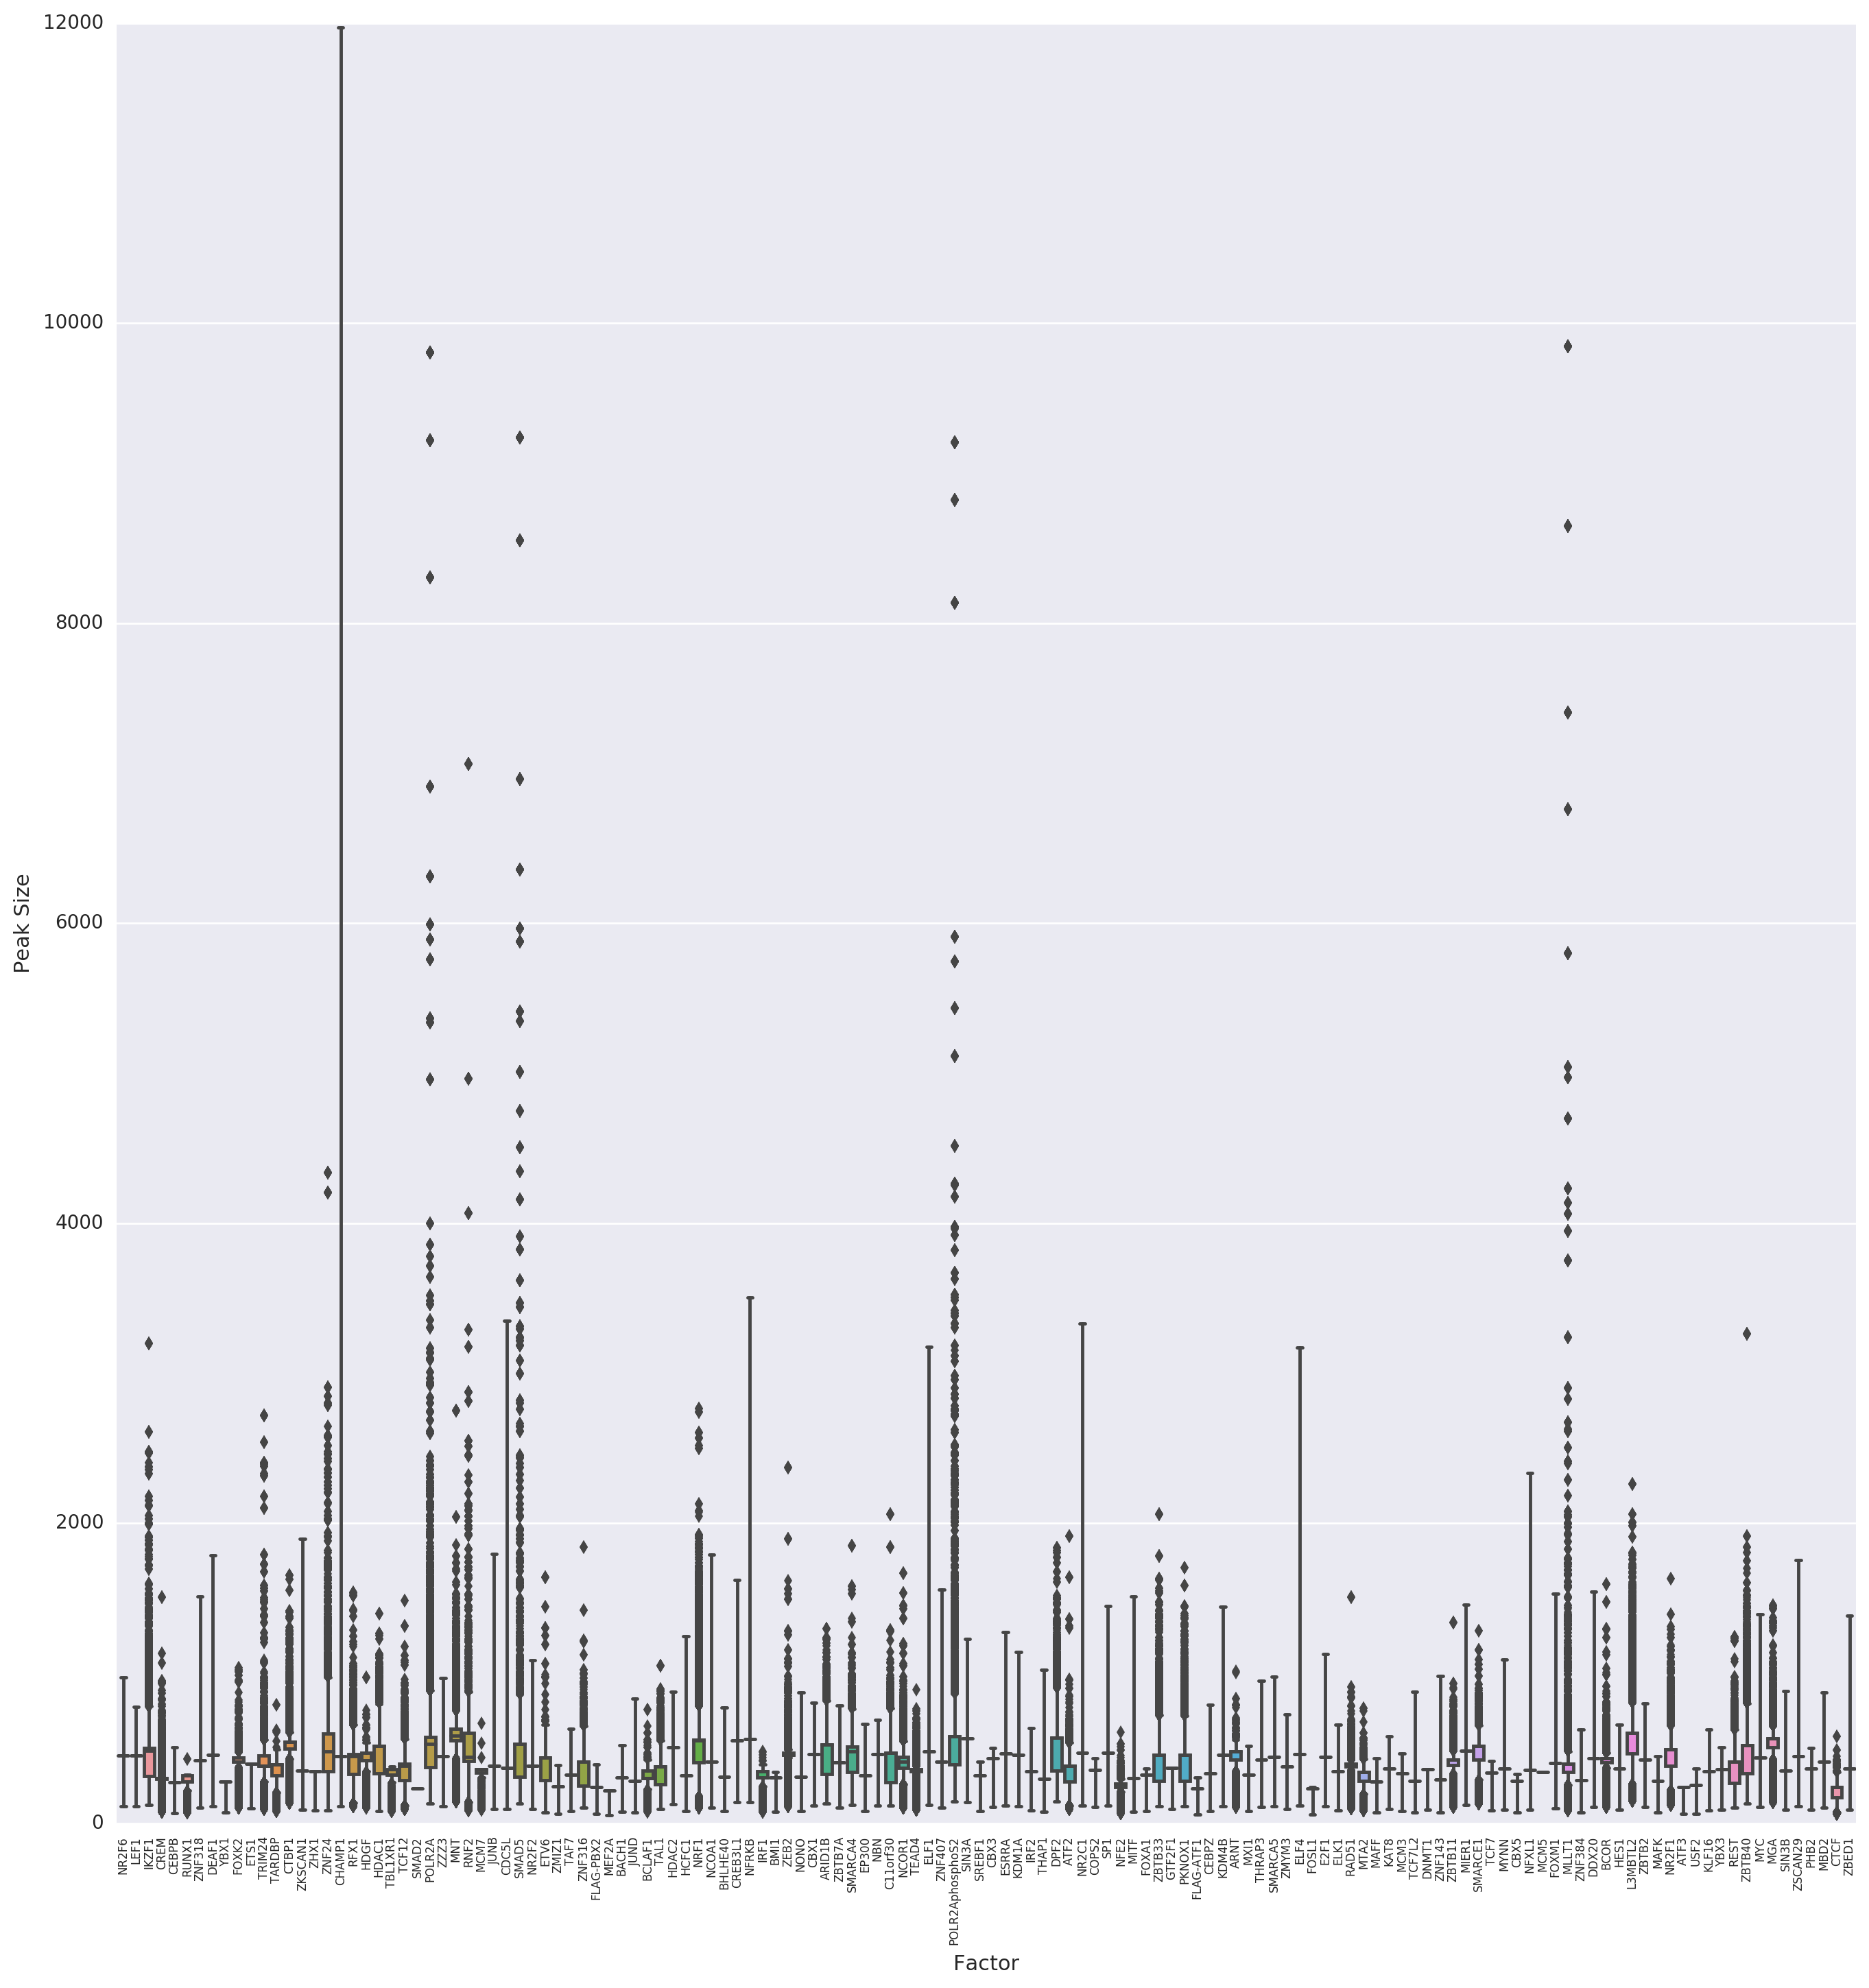

In [9]:
sns.factorplot(data = peakSize_frame, x = 'Factor', y= 'Peak Size', size=14, kind='box')
plt.xticks(rotation = 90, size=6);

In [10]:
metadata_frame = pd.DataFrame({'Factor':factors,
                               'Accession':accessions,
                               'Num Peaks':numPeaks,
                               'Mean Peak Size': mean_sizes,
                               'File Name': file_names})

In [11]:
filtered_metadata_frame = metadata_frame[metadata_frame['Num Peaks'] > 1000]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


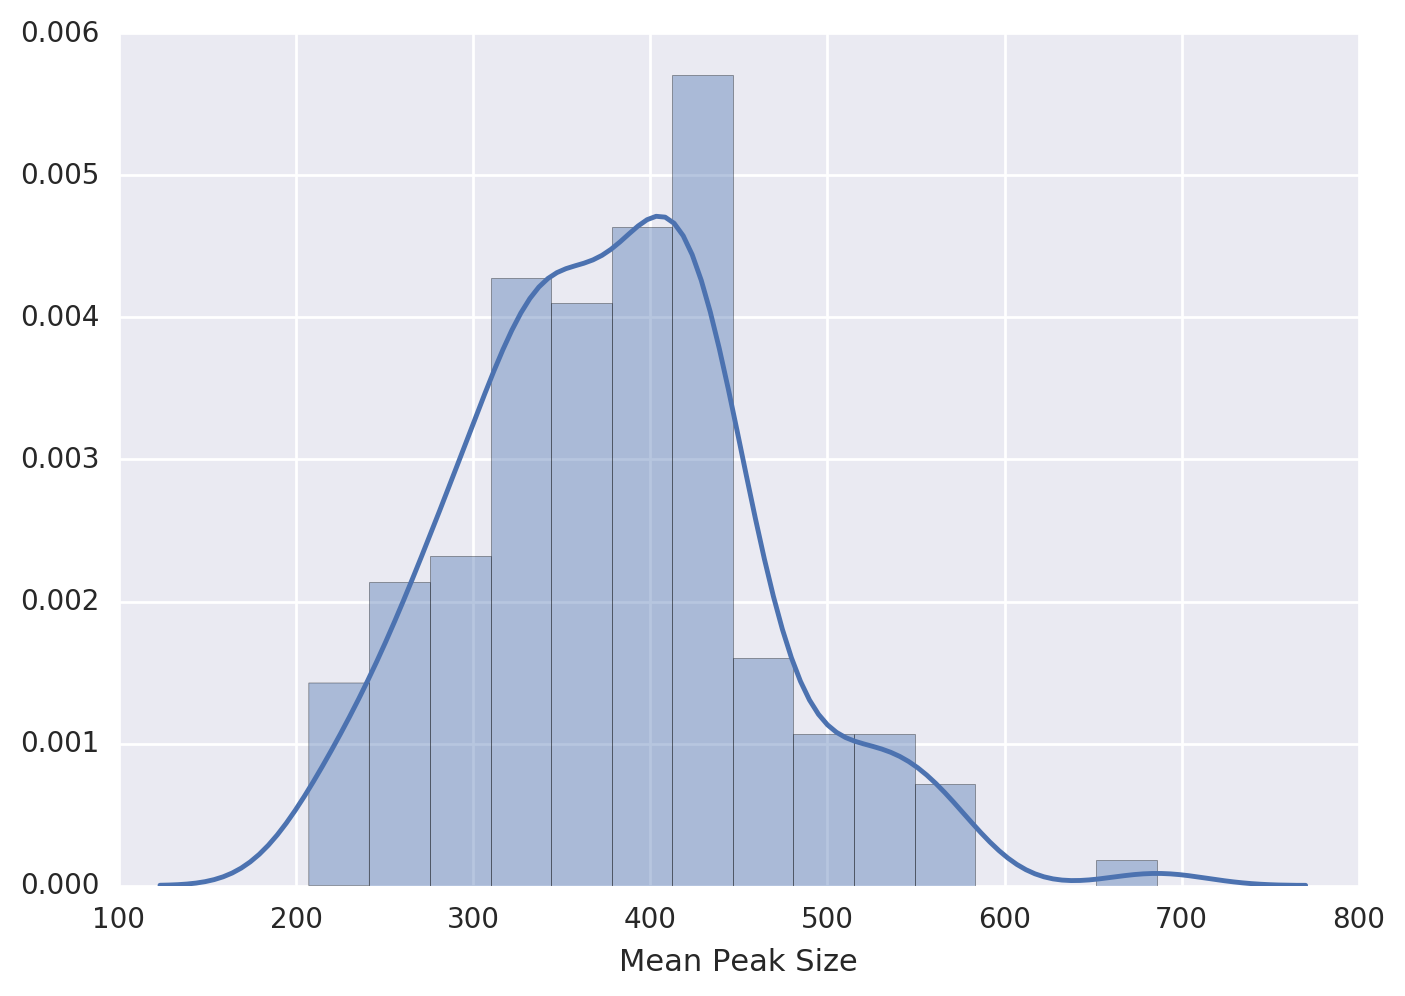

In [12]:
sns.distplot(filtered_metadata_frame['Mean Peak Size'])

In [ ]:
peak_size = 200
if not os.path.isdir('./resized_peaks/'):
    os.mkdir('./resized_peaks/')
for fn in filtered_metadata_frame['File Name'].values:
    peak_frame = pd.read_csv('./idr_peaks/' + fn, sep='\t', names = ['chrom',
                                                                     'chromStart',
                                                                     'chromEnd',
                                                                     'name',
                                                                     'score',
                                                                     'strand',
                                                                     'signalValue',
                                                                     'pValue',
                                                                     'qValue',
                                                                     'peak'])
    peak_sizes = peak_frame['chromEnd'] - peak_frame['chromStart']
    centers = peak_frame['chromStart'] + (peak_sizes/2)
    new_starts = centers - peak_size/2
    new_ends = centers + peak_size/2
    peak_frame['chromStart'] = new_starts.astype(int)
    peak_frame['chromEnd'] = new_ends.astype(int)
    peak_frame.to_csv('./resized_peaks/' + fn, sep='\t', index=False, header=False)


### Filter away random peaks

In [151]:
peak_size = 200
if not os.path.isdir('./filtered_peaks/'):
    os.mkdir('./filtered_peaks/')
for fn in filtered_metadata_frame['File Name'].values:
    peak_frame = pd.read_csv('./resized_peaks/' + fn, sep='\t', names = ['chrom',
                                                                     'chromStart',
                                                                     'chromEnd',
                                                                     'name',
                                                                     'score',
                                                                     'strand',
                                                                     'signalValue',
                                                                     'pValue',
                                                                     'qValue',
                                                                     'peak'])
    peak_frame = peak_frame[(~peak_frame['chrom'].str.contains('random')) &
                            (~peak_frame['chrom'].str.contains('chrUn')) &
                            (~peak_frame['chrom'].str.contains('alt')) &
                            (~peak_frame['chrom'].str.contains('chrY')) &
                            (~peak_frame['chrom'].str.contains('chrM')) &
                            (~peak_frame['chrom'].str.contains('chrEBV'))]
    peak_frame.to_csv('./filtered_peaks/' + fn, sep='\t', index=False, header=False)


## De novo motif analysis

In [ ]:
if not os.path.isdir('./denovo_motif_analysis'):
    os.mkdir('./denovo_motif_analysis')
for peak_file in os.listdir('./filtered_peaks/'):
    output_directory = './denovo_motif_analysis/' + '_'.join(peak_file.split('_')[:-1])
    print('findMotifsGenome.pl ./filtered_peaks/' +peak_file + ' hg38 ' + output_directory + ' -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif')
    os.system('findMotifsGenome.pl ./filtered_peaks/' +peak_file + ' hg38 ' + output_directory + ' -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif')

findMotifsGenome.pl ./resized_peaks/NR2F6-human_1_ENCFF194VBK.bed hg38 ./denovo_motif_analysis/NR2F6-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/LEF1-human_1_ENCFF134HQP.bed hg38 ./denovo_motif_analysis/LEF1-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/IKZF1-human_2_ENCFF785BTP.bed hg38 ./denovo_motif_analysis/IKZF1-human_2 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/CREM-human_1_ENCFF021XJN.bed hg38 ./denovo_motif_analysis/CREM-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/CEBPB-human_1_ENCFF321KQD.bed hg38 ./denovo_motif_analysis/CEBPB-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/RUNX1-human_2_ENCFF545WXN.bed hg38 ./denovo_motif_analysis/RUNX1-human_2 -size 200 -S 5 -p 8 -noknown -

In [ ]:
%%bash
# move motifs
for i in ./denovo_motif_analysis/*/; do echo $i; motif=${i#./*/}; motif=${motif%/}; cp $i/homerResults/motif1.motif ./motifs/${motif}.txt ;done

## Score Motif Similarity and Cluster

In [82]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/scoreMotifs.py ./motifs/ ./motif_similarity_scores

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [96]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/thresholdClusterMotifs.py ./motif_similarity_scores/correlation.npz ./motifs/ 0.80 ./clustered_motifs

## Extract Sequences Under Peaks

In [ ]:
%%bash
rm ./sequences/*
for i in ./filtered_peaks/*bed;
do output=${i/.bed/.txt};
output=${output/filtered_peaks/sequences};
# echo "homerTools extract $i /home/jtao/software/homer/data/genomes/hg38/ > $output";
homerTools extract $i /home/jtao/software/homer/data/genomes/hg38/ > $output
done

In [145]:
def read_bed_file(input_path):
    '''
    reads a bed file and returns the genomic coordinates
    '''
    with open(input_path) as f:
        data = f.readlines()
    coordinates = []
    for line in data:
        tokens = line.strip().split()
        chrom = tokens[0]
        start = tokens[1]
        end = tokens[2]
        coordinates.append((chrom,start, end))
    return coordinates

In [149]:
def extract_sequence(coordinates, genome, out_file_path):
    '''
    Given a list of genomic coordinates, extracts sequences
    inputs: [(chrom1, start1, end1), ..., (chromN, startN, endN)]
    outputs: [seq1, seq2, ...seqN]
    '''
    if genome == 'mm10':
        genome_path = '/home/jtao/code/tba/' + '/mm10/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                        'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    elif genome == 'hg38':
        genome_path = '/home/jtao/code/tba/' + '/hg38/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                        'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 
                        'chr21', 'chr22', 'chrX']
    chrom_size_dict = {}
    chrom_seq_dict = {}

    print('reading genome', genome)
    for chrom in chromosomes:
        with open(genome_path + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        chrom_size_dict[chrom] = size
        chrom_seq_dict[chrom] = seq 
    
    out_file = open(out_file_path, 'w')
    for coord in coordinates:
        chrom = coord[0]
        # chrom_seq dict is 0 indexed, genome coords are 1 indexed
        start = int(coord[1]) - 1
        end = int(coord[2]) - 1
        seq = chrom_seq_dict[chrom][start:end] 
        id_line = '>' + str(coord[0]) + ':' +str(coord[1]) + '-' + str(coord[2]) + '\n'
        out_file.write(id_line)
        out_file.write(seq + '\n')
    out_file.close()


In [162]:
peak_dir = './filtered_peaks/'
sequence_dir = './sequences_new/'
if not os.path.isdir(sequence_dir):
    os.mkdir(sequence_dir)
counter = 0
for pf in os.listdir(peak_dir):
    coordinates = read_bed_file(peak_dir + '/' + pf)
    output_path = sequence_dir + '/' + pf.replace('.bed','.txt')
    if not os.path.isfile(output_path):
        counter +=1
        extract_sequence(coordinates, 'hg38', output_path)
#         print('/home/jtao/code/tba/extract_sequences.py ' + peak_dir + '/' + pf + ' hg38 '+output_path)

## Construct Background Regions

In [59]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background; fi
for i in ./filtered_peaks/*bed;
do 
factor=${i##*/};
factor=${factor%_*};
fasta_path="./background/${factor}.fasta"
bed_path="./background/${factor}.bed"
if [ ! -f $fasta_path ];
then
# echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome hg38";
# echo "mv ./background/background.bed $bed_path";
# echo "mv ./background/background.fasta $fasta_path";
echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome hg38" >> $script_path;
echo "mv ./background/background.bed $bed_path" >> $script_path;
echo "mv ./background/background.fasta $fasta_path" >> $script_path;
fi
done

## Read in Motifs

In [98]:
def read_motif_file(motifPath):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [99]:
motif_dir = './motifs/'
all_motifs = []
for m in os.listdir(motif_dir):
    motif = read_motif_file(motif_dir + '/' + m)
    all_motifs.append(motif)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


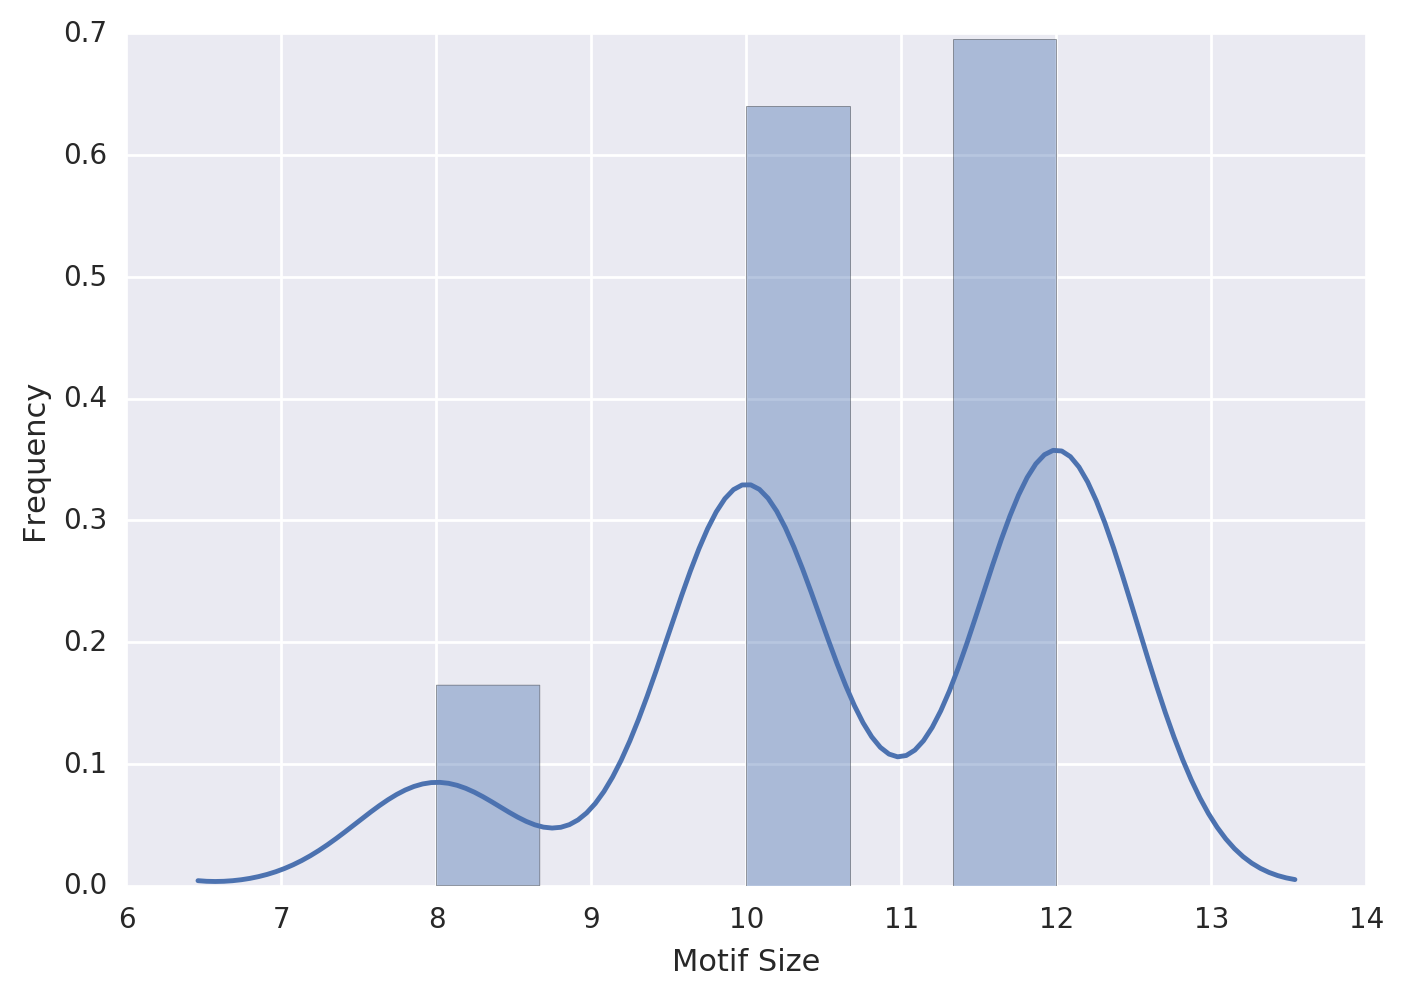

In [108]:
lengths = []
for motif in all_motifs:
    lengths.append(motif[1].shape[0])
sns.distplot(lengths)
plt.xlabel('Motif Size')
plt.ylabel('Frequency')

## Calculate Motif Scores

In [168]:
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

### Foreground

In [173]:
all_motifs[0][1].shape

(10, 4)

In [175]:
nucleotide_array_dict = {'A': [1, 0, 0, 0],
                         'C': [0, 1, 0, 0],
                         'G': [0, 0, 1, 0],
                         'T': [0, 0, 0, 1]}

In [227]:
scores.sort(key = lambda x:x[0], reverse = True)

In [ ]:
motif_dir = './motifs/'
seq_dir = './sequences_new/'
seq_paths = sorted([x for x in os.listdir(seq_dir)])
pseudo_count = 0.0001
for sp in seq_paths:
    with open(seq_dir + '/' +sp) as f:
        data = f.readlines()
    print(sp)
    counter = 0   
    id_list = []
    sequence_array_list = []
    # loop through each sequence
    # convert sequence to array
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            seq_array = []
            for nuc in seq:
                seq_array.append(nucleotide_array_dict[nuc])
            seq_array = np.array(seq_array)
            sequence_array_list.append(seq_array)
            
    # calculate scores for each motif at each position
    motif_score_dict= {}
    motif_start_dict = {}
    motif_end_dict = {}
    for motif in all_motifs:
        pwm = motif[1]
        motif_name = motif[0]
        pwm_length = pwm.shape[0]
        
        top_scores = []
        top_starts = []
        top_ends = []
        for seq_array in sequence_array_list[:1000]:
            counter +=1
            if counter %1000 ==0:
                print(counter)
            seq_length = seq_array.shape[0]
            scores = []
            for i in range(seq_length - pwm_length):
                subseq_array = seq_array[i: i + pwm_length] # get substring represented as matrix
                frequencies = (pwm * subseq_array).sum(axis=1) # get corresponding pwm frequencies
                ratios = (frequencies + pseudo_count)/(0.25 + pseudo_count) # 0.25 background freq
                llr = np.log2(ratios) # calculate log likelihood ratios
                score = np.sum(llr) # sum to calculate motif score
                scores.append((score, i, i + pwm_length))
            scores.sort(key = lambda x:x[0], reverse = True)
            top_hit = scores[0]
            top_scores.append(top_hit[0])
            top_starts.append(top_hit[1])
            top_ends.append(top_hit[2])
        motif_score_dict[motif_name] = top_scores
        motif_start_dict[motif_name] = top_starts
        motif_end_dict[motif_name] = top_ends
    break

ARID1B-human_1_ENCFF249TYS.txt
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


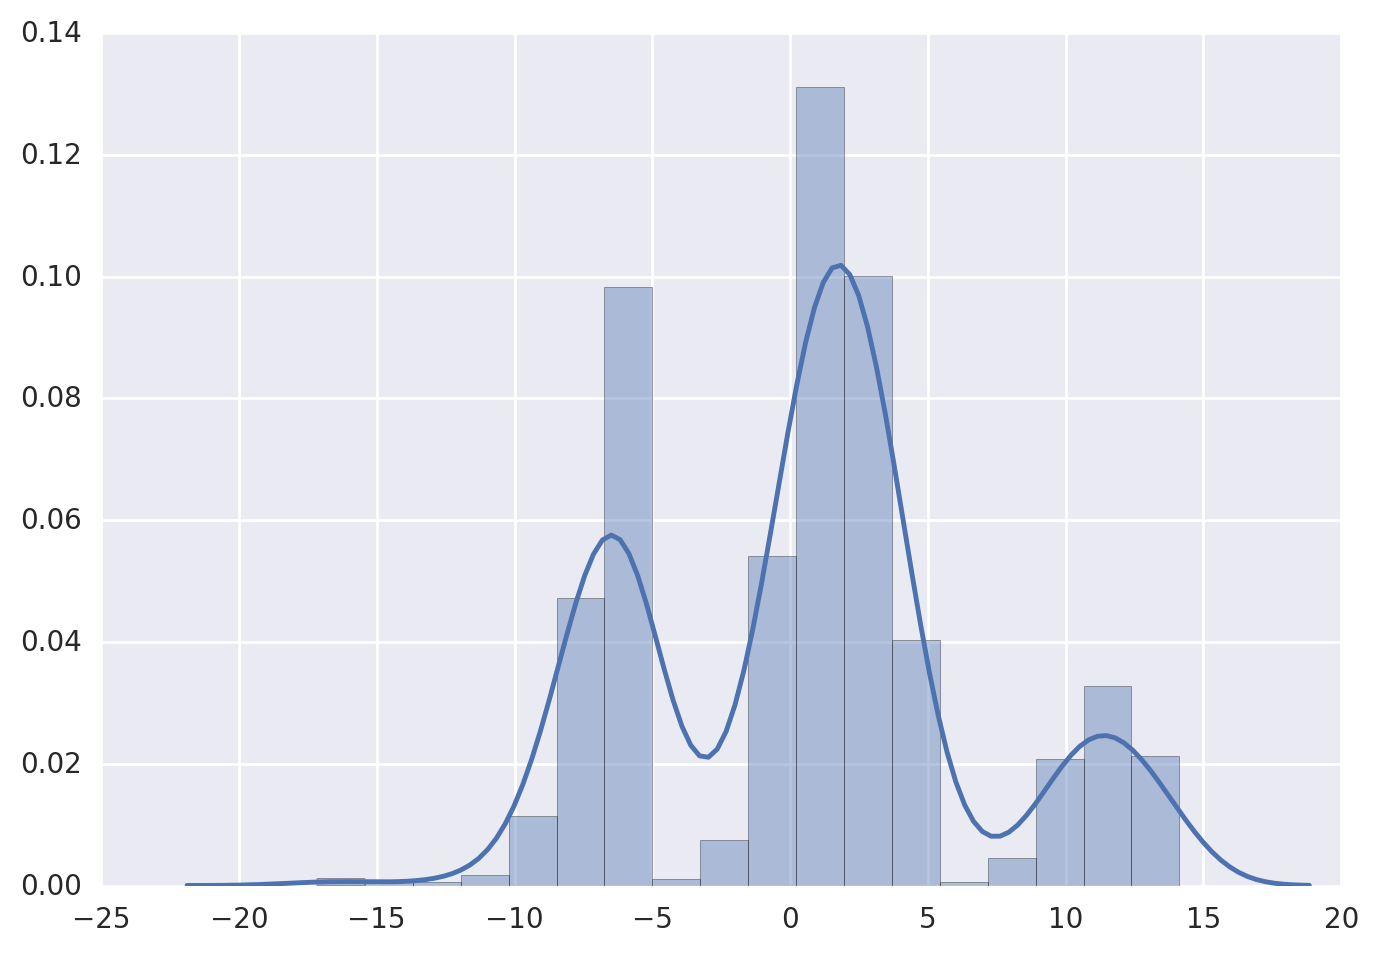

In [251]:
sns.distplot(motif_score_dict['ARID1B-human_1'])

In [109]:
!head ./resized_peaks/ATF3-human_1_ENCFF467WOR.bed

chr18	22560049	22560249	.	950	.	7.0525899999999995	-1.0	-0.38516999999999996	120
chr7	116862671	116862871	.	1000	.	7.07112	-1.0	-0.38713000000000003	120
chr21	28993256	28993456	.	1000	.	7.095330000000001	-1.0	-0.38934	120
chr22	23128992	23129192	.	714	.	7.47918	-1.0	-0.41222	120
chr1	44030342	44030542	.	657	.	7.488860000000001	-1.0	-0.41223999999999994	120
chr4	1347106	1347306	.	1000	.	7.767989999999999	-1.0	-0.41618	120
chr19	39430949	39431149	.	884	.	7.87246	-1.0	-0.4208	120
chr2	12493289	12493489	.	799	.	7.96128	-1.0	-0.41988000000000003	120
chr1	45012881	45013081	.	896	.	8.05091	-1.0	-0.42846999999999996	120
chr1	155001171	155001371	.	590	.	8.1595	-1.0	-0.43736	120


### Background

## Calculate Bayesian Markov Models

## Calculate Scores for Bayesian Markov Models